In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from scipy.linalg import svd
from collections import defaultdict
from scipy.stats import mode, itemfreq
from scipy import delete
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC as SVM
import operator
from biom import load_table
from random import randint
import seaborn as sns
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE
import math
from wpca import WPCA, EMPCA
from gneiss.sort import mean_niche_estimator, niche_sort
from gneiss.util import match
from gneiss.balances import balance_basis
from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv,inner, perturb_inv, clr, clr_inv, centralize)
from skbio import TreeNode, DistanceMatrix
from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean
import copy
from r_pca import R_pca #alternate completion than fancy impute
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from base_impute import base
from error_impute import error
from Impute_utils_vis import PCA_niche
from skbio.stats.composition import centralize, clr
from sklearn import preprocessing
%matplotlib inline

Using TensorFlow backend.


In [2]:
def fancy_dendrogram(*args, **kwargs):
    
    '''''
    From https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    '''''
    
    
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('Sample Index or (Cluster Size)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### From gneiss https://github.com/biocore/gneiss

In [3]:
def convert_biom_to_pandas(table):


    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,index=table.ids(axis='sample'),columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    for key, value in mapping.items():
        nvalue = ';'.join(value[1:])
        mapping.update({key:nvalue})
    taxonomy = pd.DataFrame(mapping, index=['taxonomy']).T
    
    
    return feature_table, taxonomy

# This is the DEICODE method applied to the EMP dataset

### Import .biom, taxonomy and meta data

In [4]:
#Mapping

mappingdf= pd.read_table('data/2kEMP.txt', index_col=0)                   
samplenames = mappingdf.index.values.tolist()
samplenames = map(str, samplenames)

In [5]:
#BIOM

#load table 
table = load_table('data/2kEMP.biom')
read_filter = lambda val, id_, md: sum(val) > 0
table.filter(read_filter, axis='sample') 
table.filter(read_filter, axis='observation')
otu, taxonomy = convert_biom_to_pandas(table)
otu=otu.T

#add taxa names
taxa_names=list(taxonomy['taxonomy'])
#otu = otu.set_index('taxa')

#add unque taxa names for now
otus_index=[]
for q in range(len(otu.index.values)):
    otus_index.append("OTU_%s"%str(q))
otu['new_index']=otus_index
otu = otu.set_index('new_index')

In [6]:
#check matching
otu, mappingdf = match(otu.T, mappingdf)
otu=otu.T
# save data and names from data frame
index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = map(str, ids)

In [7]:
otu.T.head()

new_index,OTU_0,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,...,OTU_220045,OTU_220046,OTU_220047,OTU_220048,OTU_220049,OTU_220050,OTU_220051,OTU_220052,OTU_220053,OTU_220054
933.W.3.1.S.E.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1747.RGZ.7172012.H.saliva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1039.P.Abraao.SB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
662.M26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
722.TRRsed3.4.s.4.1.sequence,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
mappingdf.head()

,BarcodeSequence,LinkerPrimerSequence,Description,host_subject_id,study_id,title,principal_investigator,doi,ebi_accession,pcr_primers,...,adiv_shannon,adiv_faith_pd,temperature_deg_c,ph,salinity_psu,oxygen_mg_per_l,phosphate_umol_per_l,ammonium_umol_per_l,nitrate_umol_per_l,sulfate_umol_per_l
#SampleID,,,,,,,,,,,,,,,,,,,,,
933.W.3.1.S.E.2,CCAGTATCGCGT,GTGCCAGCMGCCGCGGTAA,DNA from surface swab of Ecklonia radiat...,UNSW0332,933,Latitudinal surveys of algal-associated microo...,Torsten Thomas,10.1111/1462-2920.12972,None,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,...,5.551435,32.836288,23.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1747.RGZ.7172012.H.saliva,TTCTCTCGACAT,GTGCCAGCMGCCGCGGTAA,Humvee saliva,7,1747,The oral and skin microbiomes of captive Komod...,Rob Knight,10.1128/mSystems.00046-16,ERP016252,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,...,3.899313,21.614797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039.P.Abraao.SB,TTCCCTTCTCCG,GTGCCAGCMGCCGCGGTAA,NaN,P.Abraao.SB,1039,Metagenomic analysis of Rio de Janeiro coastline,Diogo Jurelevicius,None,ERP016734,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,...,8.312098,72.623851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662.M26,ATGAAGCACTGT,GTGCCAGCMGCCGCGGTAA,biofilm extracted from cover slip M26,M26,662,The role of macrobiota in structuring microbia...,Catherine Pfister,10.7717/peerj.631,ERP020507,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,...,3.816971,12.795220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
722.TRRsed3.4.s.4.1.sequence,TGTGGT,GTGCCAGCMGCCGCGGTAA,"Tijuana River Reserve, depth 3",TRRsed3,722,Global patterns of 16S rRNA diversity at a dep...,Rob Knight,10.1073/pnas.1000080107,None,FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT,...,7.408745,84.502591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nonzeroscount=np.count_nonzero(data)
sizel = data.shape
totalentr=sizel[0]*sizel[1]
(nonzeroscount/totalentr)

0.004106025766285702

### Impute Biom

We found that Soft Impute has similliar accuracy as zeros but creates a fully dense matrix. 

#### Fancy Impute: (https://github.com/hammerlab/fancyimpute)

* `SoftImpute`: Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the [softImpute](https://web.stanford.edu/~hastie/swData/softImpute/vignette.html) package for R, which is based on [Spectral Regularization Algorithms for Learning Large Incomplete Matrices](http://web.stanford.edu/~hastie/Papers/mazumder10a.pdf) by Mazumder et. al.




In [ ]:
# remove values 

otum2=data.copy()
otum2=otum2.astype(np.float64)
otum2[otum2 == 0] = np.nan #make unknown nan 

# soft impute and zeros

print("Running soft impute")
sfi=SoftImpute(shrinkage_value=None,convergence_threshold=0.00001,max_iters=1000,max_rank=min(data.shape),n_power_iterations=1,init_fill_method="zero",min_value=0,max_value=(np.amax(otum2)),normalizer=None,verbose=True).complete(otum2)

Running soft impute
[SoftImpute] Max Singular Value of X_init = 1131385.788637


In [ ]:
new_otu_sfi = pd.DataFrame(sfi, columns=otu.columns.tolist(),index=otu.index.tolist())
new_otu_sfi.to_csv('soft_impute_EMP_2k.tsv', sep='\t')

### Encode and Impute Mapping File 

In [ ]:
# build maping file with encoded labels for all non-continous data sets

le = preprocessing.LabelEncoder()
for encode_column in list(mappingdf.columns.values):
    le.fit(list(set(list(mappingdf[encode_column]))))
    encoded = le.transform(list(mappingdf[encode_column])) 
    mappingdf[encode_column]=encoded

In [ ]:
# impute unknown mapping ?



# Machine Learning

Now that we have completed data we will be able to make better predictions through machine learning. Through this we can determine what metadata factors best describe our data. (i.e. pH for 88_Soils)

One of the best ways too speed up and boost the accuracy of our machine leanring is throuhg PCA. The reduced data is the key to what will improve our ability to learn the data. 

In [ ]:
############################# SVM , based on data composition and determine best classifier ###################################################

classifiers_meta=df.columns.values.tolist()
X =low_rank_matrix.T
sv={}

for metatmp in classifiers_meta[mapstart_num:]: 

    if len(set(metatmp))==2:

        Y=df[metatmp].tolist()
        Y = map(int, Y)
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=0)
        pca = PCA(n_components=3)
        pca.fit(X_train)
        X_t_train = pca.transform(X_train)
        X_t_test = pca.transform(X_test)
        clf = svm.SVC()
        clf.fit(X_t_train, y_train)
        sv[metatmp] = clf.score(X_t_test, y_test)

    if len(set(metatmp))>2 and 4>len(set(metatmp)):


            Y=df[metatmp].tolist()
            Y = map(int, Y)
            X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=0)
            pca = PCA(n_components=3)
            pca.fit(X_train)
            X_t_train = pca.transform(X_train)
            X_t_test = pca.transform(X_test)
            clf = svm.LinearSVC(random_state=29)
            clf.fit(X_t_train, y_train)
            sv[metatmp] = clf.score(X_t_test, y_test)

    else:

            Y=df[metatmp].tolist()
            Y = map(int, Y)
            X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=0)
            pca = PCA(n_components=3)
            pca.fit(X_train)
            X_t_train = pca.transform(X_train)
            X_t_test = pca.transform(X_test)
            clf = svm.SVR()
            clf.fit(X_t_train, y_train)
            sv[metatmp] = clf.score(X_t_test, y_test)



# Remove OTU values at the lowest frequency until density reaches desired value

To simulate the "missing" values in an OTU table density will be lowered from the original OTU table by removing the lowest frequency OTUs in reach sample. 

Note: The sum of any OTU row can not be zero or a singular matrix will be formed, preventing SVD and many of the imputation methods. 

### There are a eight different imputation methods used.

#### Fancy Impute: (https://github.com/hammerlab/fancyimpute)

* `KNN`: Nearest neighbor imputations which weights samples using the mean squared difference
on features for which two rows both have observed data.

* `SoftImpute`: Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the [softImpute](https://web.stanford.edu/~hastie/swData/softImpute/vignette.html) package for R, which is based on [Spectral Regularization Algorithms for Learning Large Incomplete Matrices](http://web.stanford.edu/~hastie/Papers/mazumder10a.pdf) by Mazumder et. al.

* `IterativeSVD`: Matrix completion by iterative low-rank SVD decomposition. Should be similar to SVDimpute from [Missing value estimation methods for DNA microarrays](http://www.ncbi.nlm.nih.gov/pubmed/11395428) by Troyanskaya et. al.

* `MICE`: Reimplementation of [Multiple Imputation by Chained Equations](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/).


#### EMPCA and WPCA: (https://github.com/jakevdp/wpca)

- ``wpca.WPCA`` uses a direct decomposition of a weighted covariance matrix to
  compute principal vectors, and then a weighted least squares optimization
  to compute principal components. It is based on the algorithm presented
  in [Delchambre (2014)](http://arxiv.org/abs/1412.4533)

- ``wpca.EMPCA`` uses an iterative expectation-maximization approach to solve
  simultaneously for the principal vectors and principal components of
  weighted data. It is based on the algorithm presented in
  [Bailey (2012)](http://arxiv.org/abs/1208.4122).

#### Nuclear Norm, Decomposition (https://github.com/dganguli/robust-pca)

* `RPCA`: Nuclear Norm,Convex optimized decomposition http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

##### Base comparison :

* `Zeros`: All unknown values are replaced with zeros. An effective method for 16S analysis due to the fact that most missing entries are low frequency.





In [7]:
############################  makes most sense (min only) #######################

# removes min value that is greater than zero (checks density) in each iteration randomly chosen 

#density range to run
end=0.04 # final density to test 
begin=(nonzeroscount/totalentr) # Begning density of matrix 
step=.01
#data=data.T
#intialize
density_in=[]
RMSE_empca_scores=[]
RMSE_wpca_scores=[]
RMSE_sfi_scores=[]
RMSE_siv_scores=[]
RMSE_sni_scores=[]
RMSE_skn_scores=[]
RMSE_smi_scores=[]
RMSE_szi_scores=[]
Density_empca=[]
Density_wpca=[]
Density_sfi=[]
Density_siv=[]
Density_sni=[]
Density_skn=[]
Density_smi=[]
Density_szi=[]

#radnomly remove values from known matrix and try to impute them 

for d in reversed(np.arange(end,begin,step)):
    otum=data.T.copy()
    nonzeroscount=np.count_nonzero(otum)
    sizel = otum.shape
    totalentr=sizel[0]*sizel[1]
    
    while np.float64((nonzeroscount/totalentr)) > d:
        ########### remove a min ###########
        j=randint(0,len(otum[:][:])-1)
        #make sure row is not all zero (not normally possible and will cause singular matrix in imputation!)
        if sum(list(otum[j][:])) < 1:
            continue 
        m = min(i for i in list(otum[j][:]) if i > 0)
        #make sure removing value will not result in zero row
        if sum(list(otum[j][:])) == m:
            continue 
        otum[j][list(otum[j][:]).index(m)]=0
        #check if under-dense 
        nonzeroscount=float(np.count_nonzero(otum))
        sizel = otum.shape
        totalentr=float(sizel[0])*float(sizel[1])
        
    # coherce float the unknown
    print("OTU table of %f generated"%d)
    otum=otum.T.astype(np.float64)

    # make zero unknown for fancy impute, avoid singular matrix by taking transpose 
    otum2=otum.T.copy()
    otum2=otum2.astype(np.float64)
    otum2[otum2 == 0] = np.nan #make unknown nan 

    #WPCA and EMPCA 
    weight = otum.copy()
    for i in range(len(otum2.T)):
        for j in range(len(otum2.T[i])):
            if otum2.T[i][j]==0:
                weight[i][j]=0
            else:
                weight[i][j]=100
            
    print("Running EMPCA")
    EMPCAi = EMPCA(n_components=3).fit_reconstruct(otum,weight)
    print("Running WPCA")
    WPCAi = EMPCA(n_components=3).fit_reconstruct(otum,weight)
    
    #nuclear norm
    
    print("Running Nuclear Norm Minimization") 
    iteration_used=100000000
    rpca = R_pca(otum)
    sni, S = rpca.fit(max_iter=iteration_used, iter_print=int(iteration_used/4))
    sni=abs(sni)
    
    #scale for fancy 
    # sometimes useful for low-rank imputation methods
    biscaler = BiScaler(center_rows=False,center_columns=False,scale_rows=False,scale_columns=False,min_value=0,max_value=(np.amax(otum)),max_iters=500,tolerance=0.00001,verbose=True)
    # rescale columns to have zero mean and unit variance
    otum2_normalized = biscaler.fit_transform(otum2.T)

    # fancy impute and zeros
    print("Running soft impute")
    sfi=SoftImpute(shrinkage_value=None,convergence_threshold=0.00001,max_iters=1000,max_rank=min(data.shape),n_power_iterations=1,init_fill_method="zero",min_value=0,max_value=(np.amax(otum2_normalized)),normalizer=None,verbose=False).complete(otum2_normalized.T)
    sfi=biscaler.inverse_transform(sfi.T)
    print("Running Iterative SVD")
    siv=IterativeSVD(rank=(min(data.shape)-1),convergence_threshold=0.00001,max_iters=1000,gradual_rank_increase=True,svd_algorithm="arpack",init_fill_method="zero",min_value=0,max_value=(np.amax(otum2_normalized)),verbose=False).complete(otum2_normalized.T)
    siv=biscaler.inverse_transform(siv.T)
    print("Running KNN")
    skn=KNN(k=12,orientation="rows",use_argpartition=True,print_interval=100,min_value=0,max_value=(np.amax(otum2_normalized)/10),normalizer=None,verbose=False).complete(otum2_normalized.T)
    skn=biscaler.inverse_transform(skn.T)
    print("Running MICE")
    smi=MICE(visit_sequence='monotone',n_imputations=100,n_burn_in=40,n_pmm_neighbors=40,impute_type='col',n_nearest_columns=np.infty,init_fill_method="mean",min_value=0,max_value=(np.amax(otum2_normalized)),verbose=False).complete(otum2_normalized.T)              
    smi=biscaler.inverse_transform(smi.T)
    print("Imputing by filling with zeros for base comparison")
    szi=base.zeros(otum2.T)
    
    ############# save the results  ##############
    
    ###### density in (after removed values) ####
    density_in.append(error.get_density(otum))
    
    ###### density imputed ####
    Density_empca.append(error.get_density(EMPCAi))
    Density_wpca.append(error.get_density(WPCAi))
    Density_sfi.append(error.get_density(sfi))
    Density_siv.append(error.get_density(siv))
    Density_sni.append(error.get_density(sni))
    Density_skn.append(error.get_density(skn))
    Density_smi.append(error.get_density(smi))
    Density_szi.append(error.get_density(szi))
    
    ##### RMSE of imputed values ####
    missing_mask = np.isnan(otum2.T) #masking 
    RMSE_empca_scores.append(error.RMSE(data,EMPCAi,missing_mask))
    RMSE_wpca_scores.append(error.RMSE(data,WPCAi,missing_mask))
    RMSE_sfi_scores.append(error.RMSE(data,sfi,missing_mask))
    RMSE_siv_scores.append(error.RMSE(data,siv,missing_mask))
    RMSE_sni_scores.append(error.RMSE(data,sni,missing_mask))
    RMSE_skn_scores.append(error.RMSE(data,skn,missing_mask))
    RMSE_smi_scores.append(error.RMSE(data,smi,missing_mask))
    RMSE_szi_scores.append(error.RMSE(data,szi,missing_mask))

OTU table of 0.110000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, error: 58607686.71191306
iteration: 987, error: 59.44387342337044
[BiScaler] Initial log residual value = -inf
[BiScaler] No room for improvement
Running soft impute
Running Iterative SVD
Running KNN
[KNN] Warning: 48199/60960 still missing after imputation, replacing with 0
Running MICE
Imputing by filling with zeros for base comparison
OTU table of 0.100000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, error: 58592740.72045279
iteration: 881, error: 36.87738421885672
[BiScaler] Initial log residual value = -inf
[BiScaler] No room for improvement
Running soft impute
Running Iterative SVD
Running KNN
[KNN] Warning: 46647/60960 still missing after imputation, replacing with 0
Running MICE
Imputing by filling with zeros for base comparison
OTU table of 0.090000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1,

KeyboardInterrupt: 

In [8]:
#save results as dataframe 
RMSEmapping = pd.DataFrame({'Density': density_in,'EMPCA': RMSE_empca_scores,'MICE': RMSE_smi_scores,'WPC': RMSE_wpca_scores,'Soft Impute': RMSE_sfi_scores,'Iterative SVD': RMSE_siv_scores,'Nuclear Norm Rank Minimization': RMSE_sni_scores,'K nearest neighbors': RMSE_skn_scores,'Zeros': RMSE_szi_scores})   
RMSEmapping.set_index(['Density'], inplace=True)
Out_density = pd.DataFrame({'density': density_in,'EMPCA': Density_empca,'MICE': Density_smi,'WPC': Density_wpca,'Soft Impute': Density_sfi,'Iterative SVD': Density_siv,'Nuclear Norm Rank Minimization': Density_sni,'K nearest neighbors': Density_skn,'Zeros': Density_szi})   
Out_density.set_index(['density'], inplace=True)

# RMSE Between Each Matrix

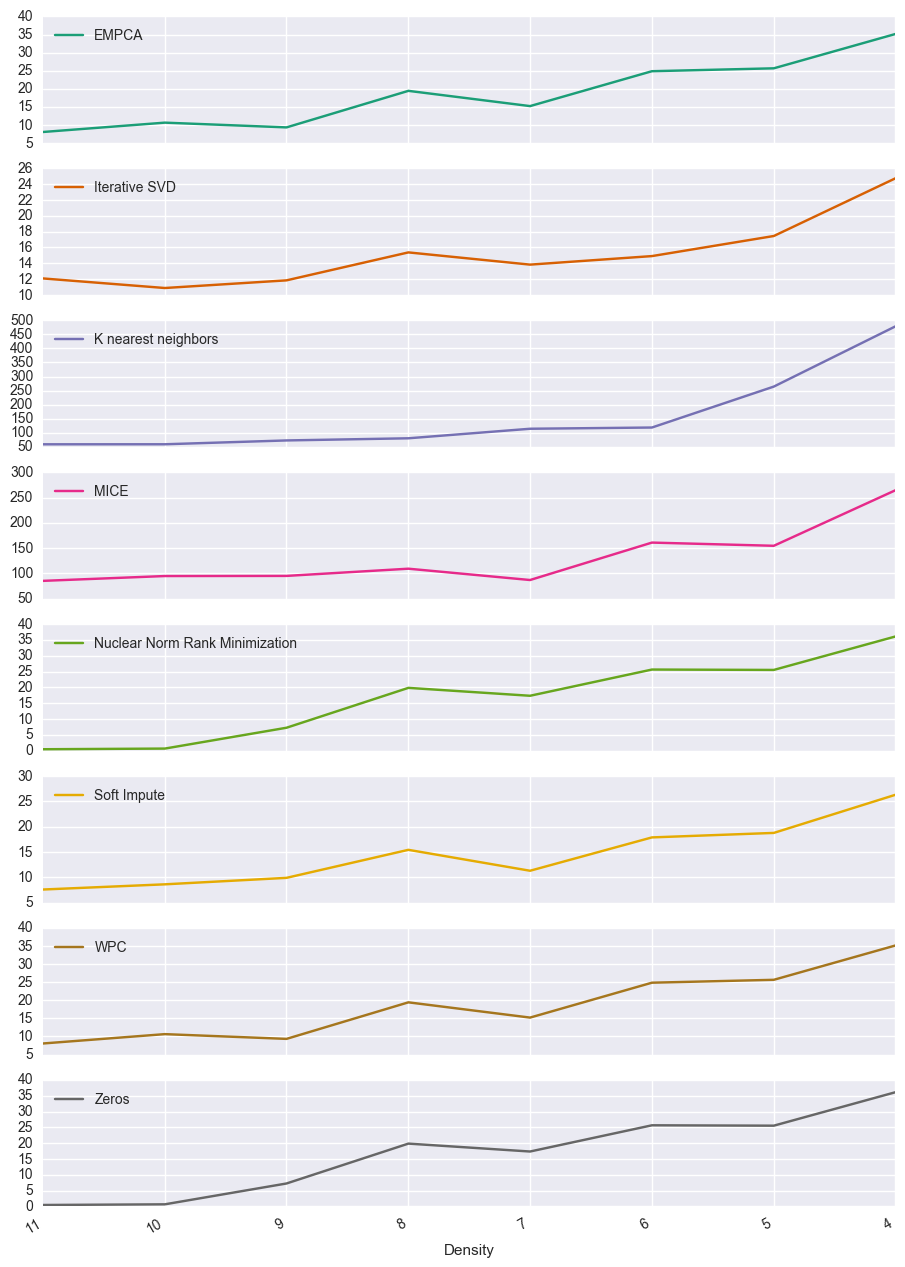

In [9]:
RMSEmapping.plot(kind='line',subplots=True,colormap="Dark2",sharex=True,sharey=False, figsize=(11, 17))
plt.show()


 In general as values are removed all methods increase in the RMSE error to the original matrix. The method used to remove values is very important. Only low frequency OTUs in each sample are removed to simulate the under or small segment sampling used in 16S studies. Because of this the zero method of imputation has a low RMSE or high accuracy. Zeros minimize the probability of being wrong by guessing the smallest possible value of zero. Nuclear Norm Rank Minimization by Convex Optimized Decomposition had the same scores as the zeros. The only downside to this method is although it is exact it does not scale well with large datasets. The next lowest RMSE are Soft Impute, WPCA, EMPCA and Iterative SVD. These may be possible contenders due to their scaleability with large datasets. 

# Density after imputation

Although zero imputation is widely used and has a low RMSE at low densities it produces very sparse matrices preventing the use of many powerful statistical tools. Below you can see at each input density (x-axis) the output density for all imputations methods is ~100% dense with exception of the k-Nearest Neighbors method. While the zero imputation adds sparsity.

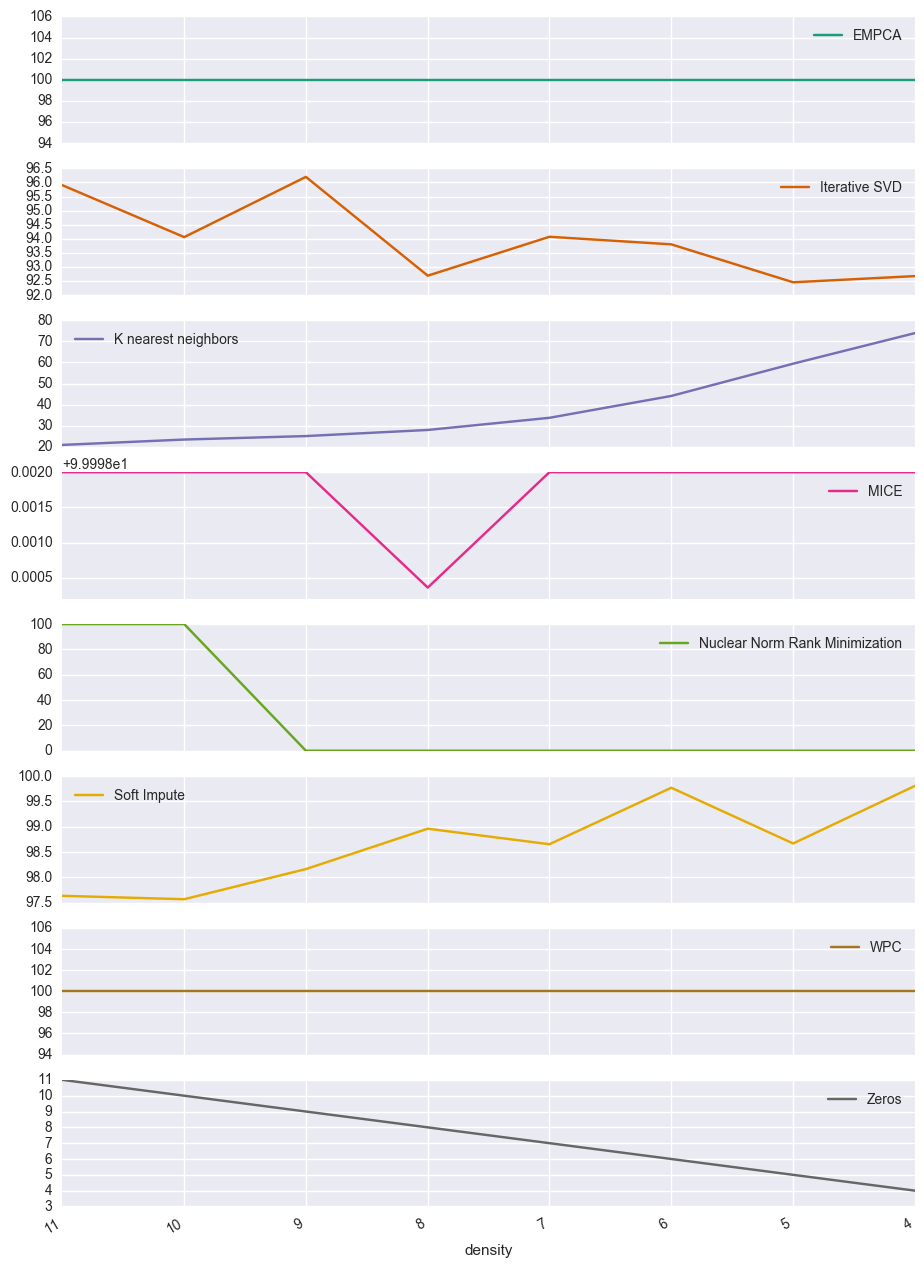

In [10]:
Out_density.plot(kind="line",subplots=True,colormap="Dark2", figsize=(11, 17))
plt.show()

# Visualize pH trend in Completion

Soft impute seems like a good ratio between RMSE, speed and density. Let's see how the pH trend in these soil samples is maintained while also creating a fully dense matrix using Soft Impute.

http://web.stanford.edu/%7Ehastie/Papers/mazumder10a.pdf

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(set(list(mappingdf.surface))))
encoded = le.transform(list(mappingdf.surface)) 
mappingdf.surface=encoded

In [28]:
le = preprocessing.LabelEncoder()
le.fit(list(set(list(mappingdf.surface))))
encoded = le.transform(list(mappingdf.surface)) 
mappingdf.surface=encoded

In [29]:
mappingdf.head()

,station,surface
sample_name,,
386.UDB31,DoorButton,0
386.UDB19,DoorButton,0
386.MDB6,DoorButton,0
386.MDB7,DoorButton,0
386.MSC8,Sink,1


In [36]:
#build dataframe and sort the pH niche 
observed_table=niche_sort(otu, mappingdf.surface)
otummapping = pd.DataFrame(otum.T, columns=otu.columns.tolist(),index=otu.index.tolist())
observed_table_m = niche_sort(otummapping, mappingdf.surface)
observed_table_m= observed_table_m[observed_table.columns.tolist()]
new_otu_sni = pd.DataFrame(sfi, columns=otu.columns.tolist(),index=otu.index.tolist())
observed_table_sni = niche_sort(new_otu_sni, mappingdf.surface)

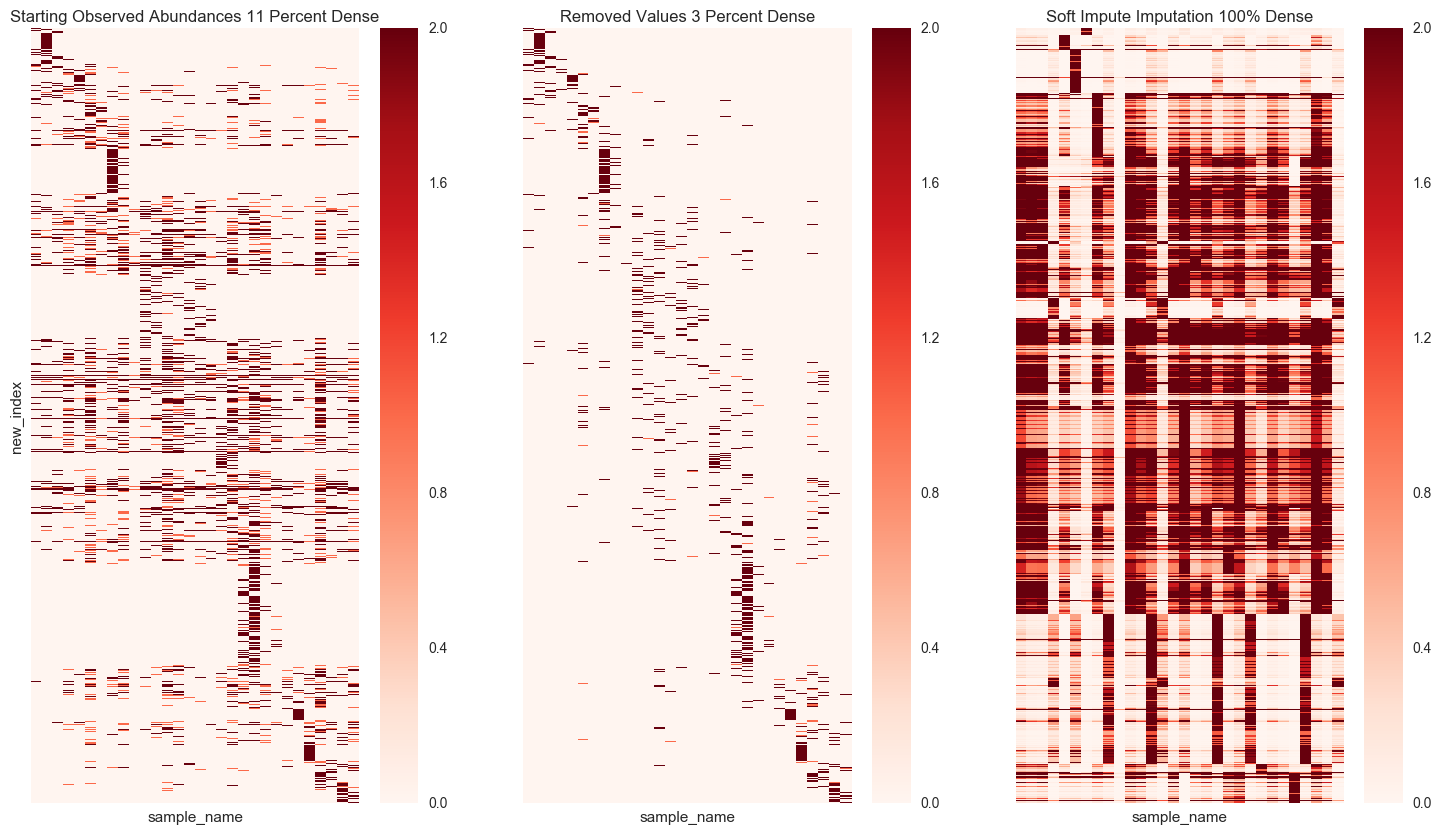

In [38]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 10))
sns.heatmap(observed_table.T, robust=True,vmin=0,vmax=2,cmap="Reds", ax=ax1)
sns.heatmap(observed_table_m.T, robust=True,vmin=0,vmax=2,cmap="Reds", ax=ax2)
sns.heatmap(observed_table_sni.T, robust=True,vmin=0,vmax=2,cmap="Reds", ax=ax3)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax1.set_title('Starting Observed Abundances %i Percent Dense'%(int(begin*100)))
ax2.set_title('Removed Values %i Percent Dense'%(int(d*100)))
ax3.set_title('Soft Impute Imputation 100% Dense')

# Run Soft Impute on Origonal Data

Running soft impute


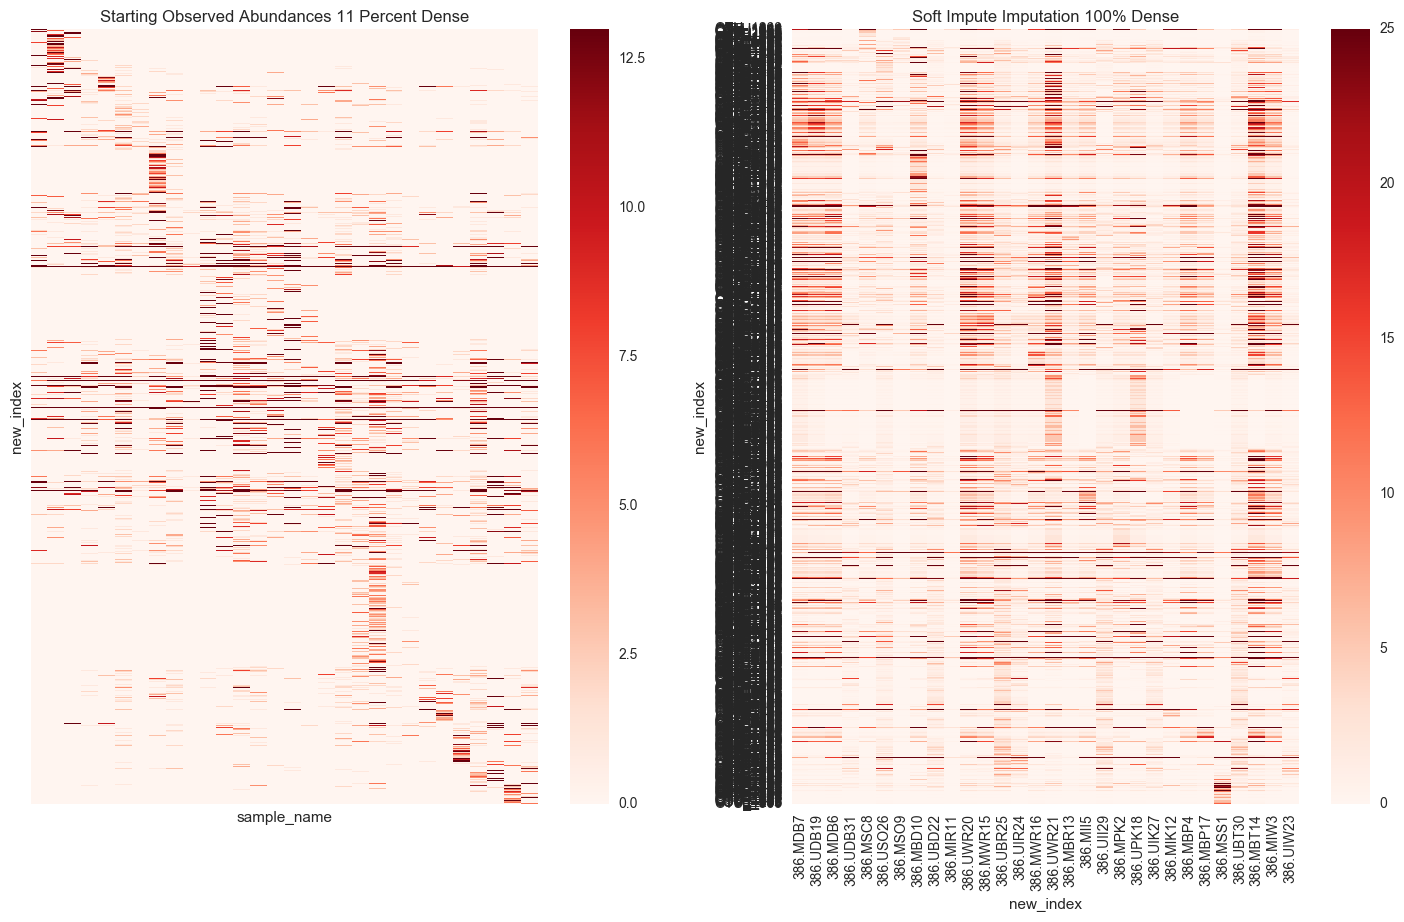

In [82]:
otum=data.T.copy()
otum2=otum.T.copy()
otum2=otum2.astype(np.float64)
otum2[otum2 == 0] = np.nan #make unknown nan 

# fancy impute and zeros
print("Running soft impute")
sfi=SoftImpute(shrinkage_value=None,convergence_threshold=0.00001,max_iters=1000,max_rank=min(data.shape),n_power_iterations=1,init_fill_method="zero",min_value=0,max_value=(np.amax(otum2_normalized)),normalizer=None,verbose=False).complete(otum2)
#build dataframe and sort the pH niche 
observed_table=niche_sort(otu, mappingdf.surface)
new_otu_sni = pd.DataFrame(sfi, columns=otu.columns.tolist(),index=otu.index.tolist())
observed_table_sni = niche_sort(new_otu_sni, mappingdf.surface)
observed_table_sni=observed_table_sni.T
observed_table_sni['new_index']=observed_table.columns.values
observed_table_sni = observed_table_sni.set_index('new_index')
observed_table_sni=observed_table_sni.T
observed_table_sni['new_index']=observed_table.index.values
observed_table_sni = observed_table_sni.set_index('new_index')


fig, (ax1,ax3) = plt.subplots(ncols=2, nrows=1, figsize=(18, 10))
sns.heatmap(observed_table.T, robust=True,cmap="Reds", ax=ax1)
sns.heatmap(observed_table_sni.T, robust=True,cmap="Reds", ax=ax3)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_title('Starting Observed Abundances %i Percent Dense'%(int(begin*100)))
ax3.set_title('Soft Impute Imputation 100% Dense')

In [83]:
observed_table_sni.head()

new_index,OTU_1269,OTU_114,OTU_111,OTU_1641,OTU_1646,OTU_1026,OTU_1671,OTU_1681,OTU_1685,OTU_965,...,OTU_377,OTU_1390,OTU_1657,OTU_931,OTU_1705,OTU_1842,OTU_938,OTU_298,OTU_1330,OTU_1563
new_index,,,,,,,,,,,,,,,,,,,,,
386.MDB7,20.000000,0.145064,0.145064,0.145064,0.290129,0.120887,0.120887,0.120887,0.120887,0.241774,...,0.030208,0.030208,0.060417,2.013896,0.070486,0.956600,4.188903,0.130903,2.957699,1.068865
386.UDB19,83.860345,0.238243,0.238243,0.238243,0.476486,0.198536,0.198536,0.198536,0.198536,0.397071,...,0.029772,0.029772,0.059544,1.984813,0.069468,0.942786,4.128410,0.129013,3.740504,1.016434
386.MDB6,67.000000,0.219587,0.219587,0.219587,0.439174,0.182989,0.182989,0.182989,0.182989,0.365979,...,0.042578,0.042578,0.085155,2.838502,0.099348,1.348288,5.904084,0.184503,6.061042,1.762907
386.UDB31,0.555298,0.006421,0.006421,0.006421,0.012841,0.005351,0.005351,0.005351,0.005351,0.010701,...,0.012394,0.012394,0.024789,0.826287,0.028920,0.392486,1.718676,0.053709,3.000000,0.978031
386.MSC8,3023.000000,6.000000,6.000000,6.000000,12.000000,5.000000,5.000000,5.000000,5.000000,10.000000,...,0.011516,0.011516,0.023032,0.767724,0.026870,0.364669,1.596866,0.049902,1.610201,0.562111


In [84]:
otu.head()

new_index,OTU_0,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,...,OTU_2022,OTU_2023,OTU_2024,OTU_2025,OTU_2026,OTU_2027,OTU_2028,OTU_2029,OTU_2030,OTU_2031
386.UDB31,1.0,0.0,0.0,3.0,18.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386.UBD22,1.0,0.0,1.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386.UIK27,1.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
386.UII29,1.0,0.0,2.0,4.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
386.MWR16,0.0,3.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,13.0


# PCA (DEICODE example)

Having a fully dense matrix allows you to use many statical tools you can not use with zero imputation due to sparsity and outliers. You can use the imputed matrix for PCA.

(https://github.com/cjm007/DEICODE)

#### PCA on origonal data density of  ~11%

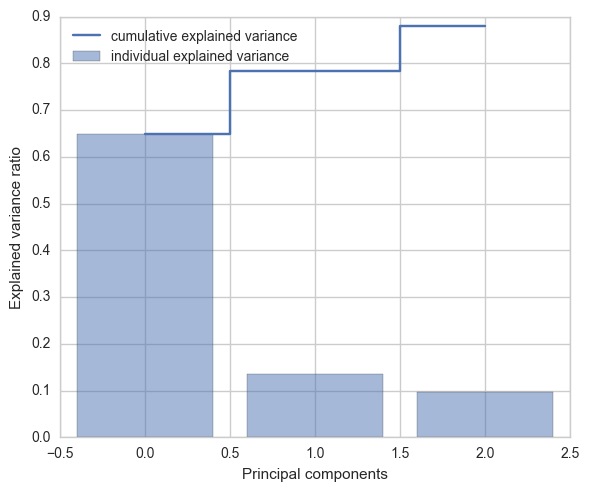

In [85]:
#check matching
observed_table_m, mapping = match(observed_table, mappingdf)
pca_model2=PCA(n_components=3)
X1=observed_table_m.as_matrix()
X_reduced1 = pca_model2.fit_transform(X1)
var_exp=pca_model2.explained_variance_ratio_
cum_var_exp = np.cumsum(pca_model2.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6,5))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

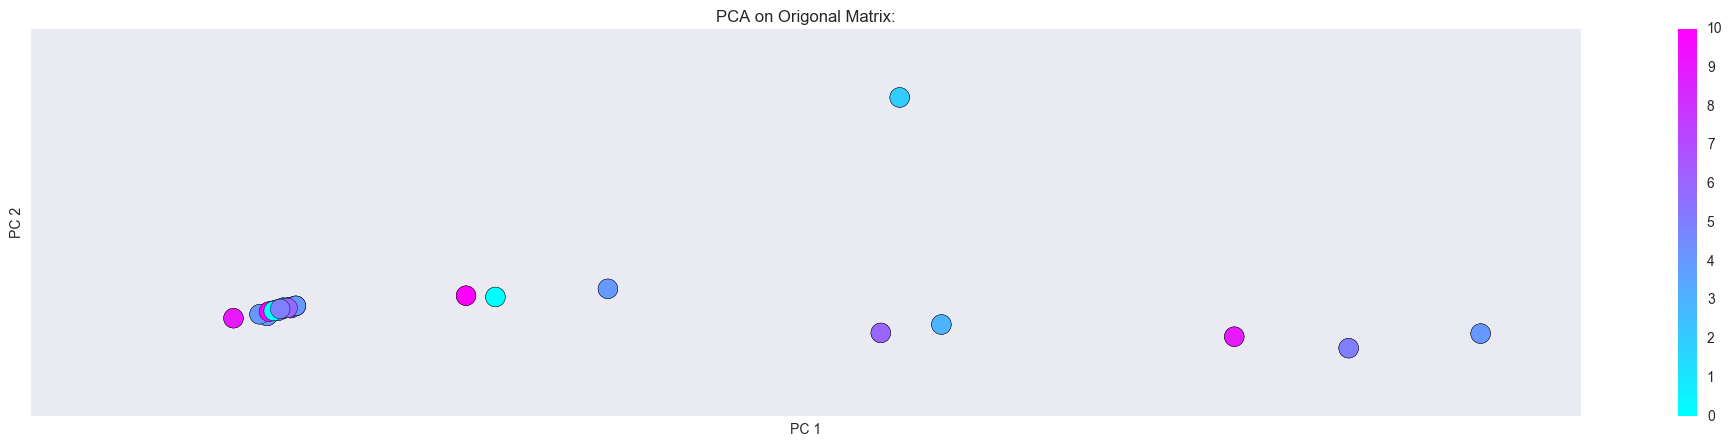

In [86]:
#plot pca
Y=mapping["surface"].tolist()
plt.figure(2, figsize=(25,5))
plt.scatter(X_reduced1[:, 0], X_reduced1[:, 1], c=Y,cmap=plt.cm.cool,s=200)
p=plt.scatter(X_reduced1[:, 0], X_reduced1[:, 1], c=Y,cmap=plt.cm.cool,s=200)
plt.title("PCA on Origonal Matrix:")
plt.xlabel("PC 1", fontsize=10)
plt.xticks([])
plt.yticks([])
plt.ylabel("PC 2", fontsize=10)
plt.colorbar(p)
plt.show()

As you can see the zero impute data how low explained variance in the first three axis and a large outlier. 

#### PCA on Iterative SVD data, 100% dense

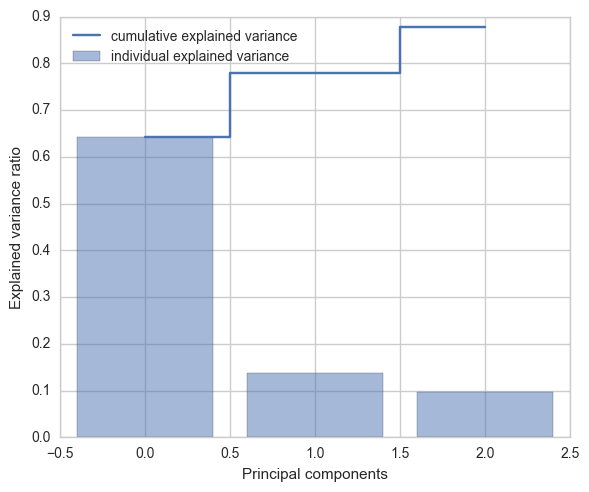

In [87]:
#check matching
observed_table_sni, mapping = match(observed_table_sni, mappingdf)
pca_model=PCA(n_components=3)
X2=observed_table_sni.as_matrix()
X_reduced2 = pca_model.fit_transform(X2)
var_exp=pca_model.explained_variance_ratio_
cum_var_exp = np.cumsum(pca_model.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6,5))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

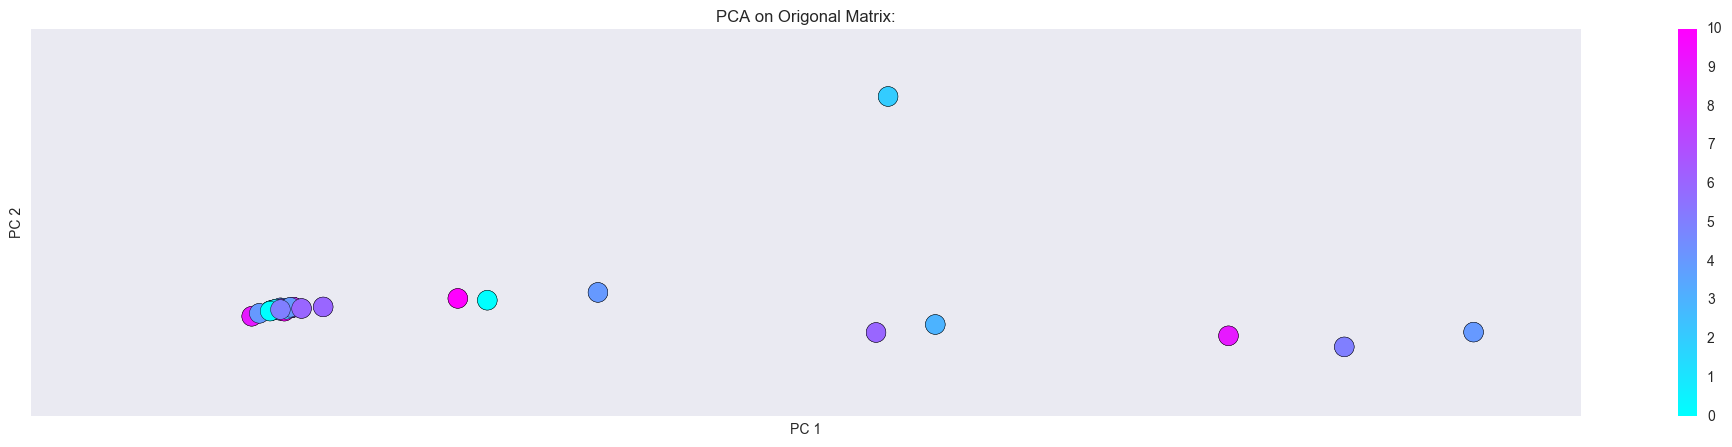

In [88]:
#plot pca
Y=mapping["surface"].tolist()
plt.figure(2, figsize=(25,5))
plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=Y,cmap=plt.cm.cool,s=200)
p=plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=Y,cmap=plt.cm.cool,s=200)
plt.title("PCA on Origonal Matrix:")
plt.xlabel("PC 1", fontsize=10)
plt.xticks([])
plt.yticks([])
plt.ylabel("PC 2", fontsize=10)
plt.colorbar(p)
plt.show()

In the complete data the outlier is no longer present and the explained variance is vastly increased.

This allows you to extract what OTUs cause the most variance on the axis that explains your data best.

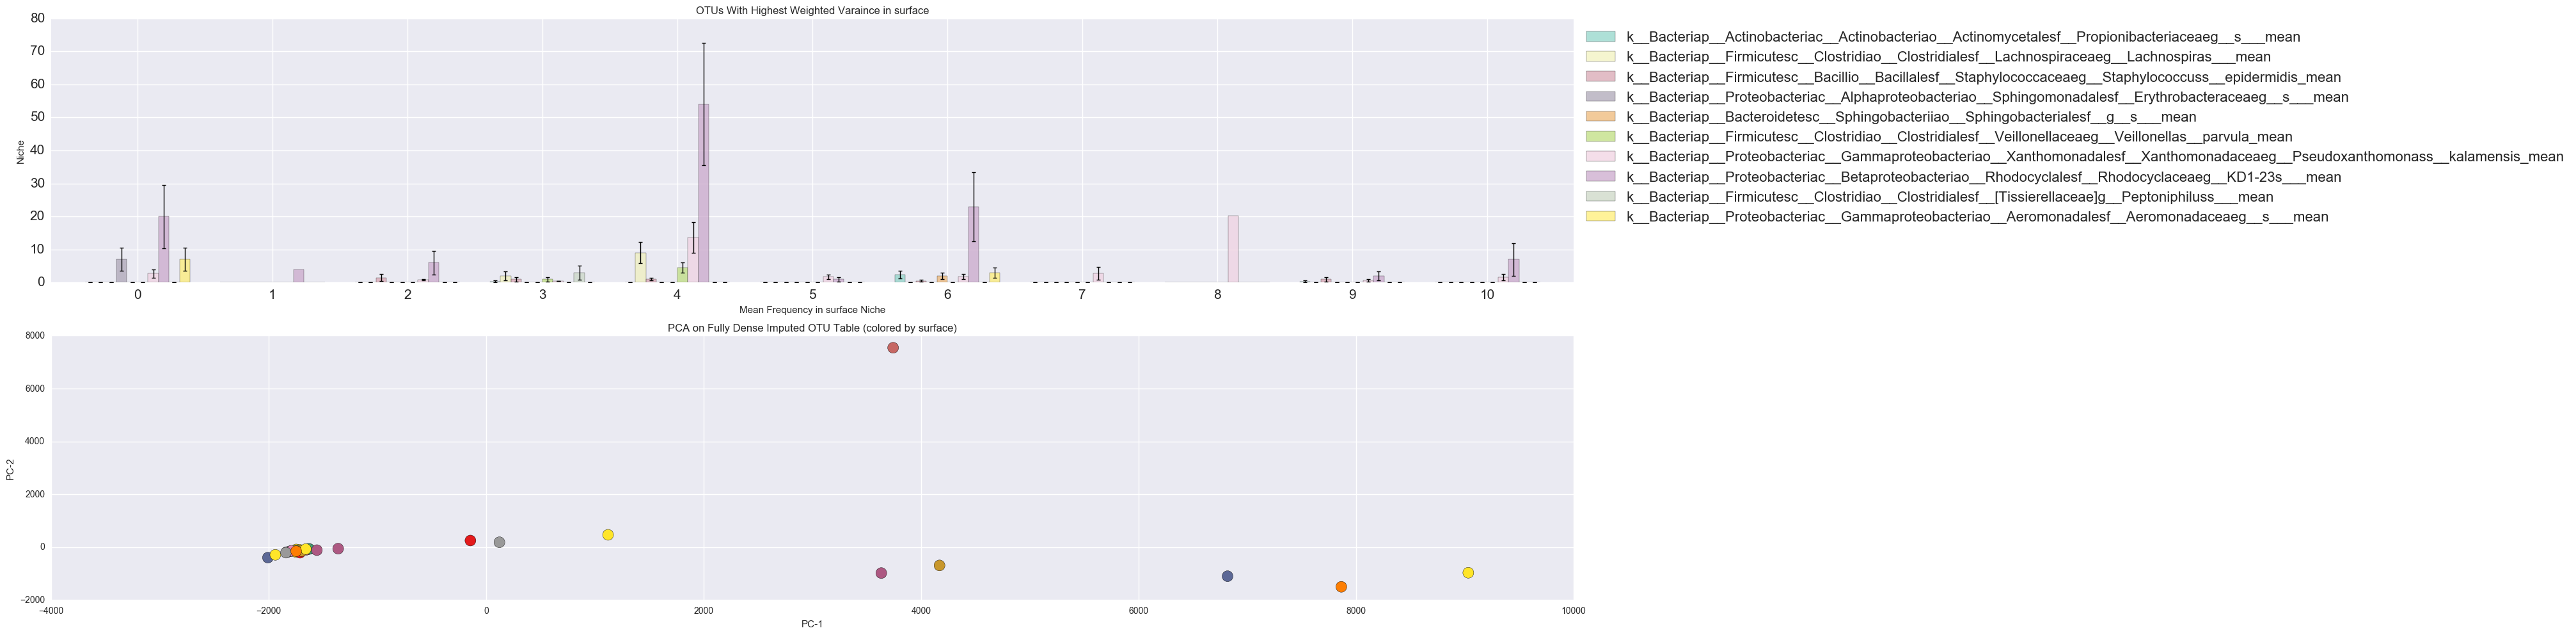

In [89]:
#cond
otu # orignal data
tax_index #list of taxa in order of otus (0-end)
bact_to_show=10 # nuber of bacteria to extract
niche_plot='surface' # any column from mapping
Pc_plot="PC-1" # can be PC-2
imputed_in=sfi.copy() # imputed data to use
cont=False # default true, false if not continous data
le # label encoder scikit
# Extract information from imputed PCA axis  
out_niche_linkeddf,observed_table_sfi,index_mean,index_std = PCA_niche.niche_visual(otu,sfi,tax_index,bact_to_show,niche_plot,Pc_plot,mappingdf)
# Visualize the data
plt = PCA_niche.plot_niche(out_niche_linkeddf,observed_table_sfi,mappingdf,niche_plot,Pc_plot,index_mean,index_std,le,cont)
plt.show()

# Ward Clustering for Balance Trees Using 100% Dense Matrix 

Balance trees for compositional data is a very important component of 16S data analysis. One difficulty for balances is building a tree due to the sparsity induced from zero imputation. This dense matrix imputation can help solve this problem.  https://github.com/biocore/gneiss

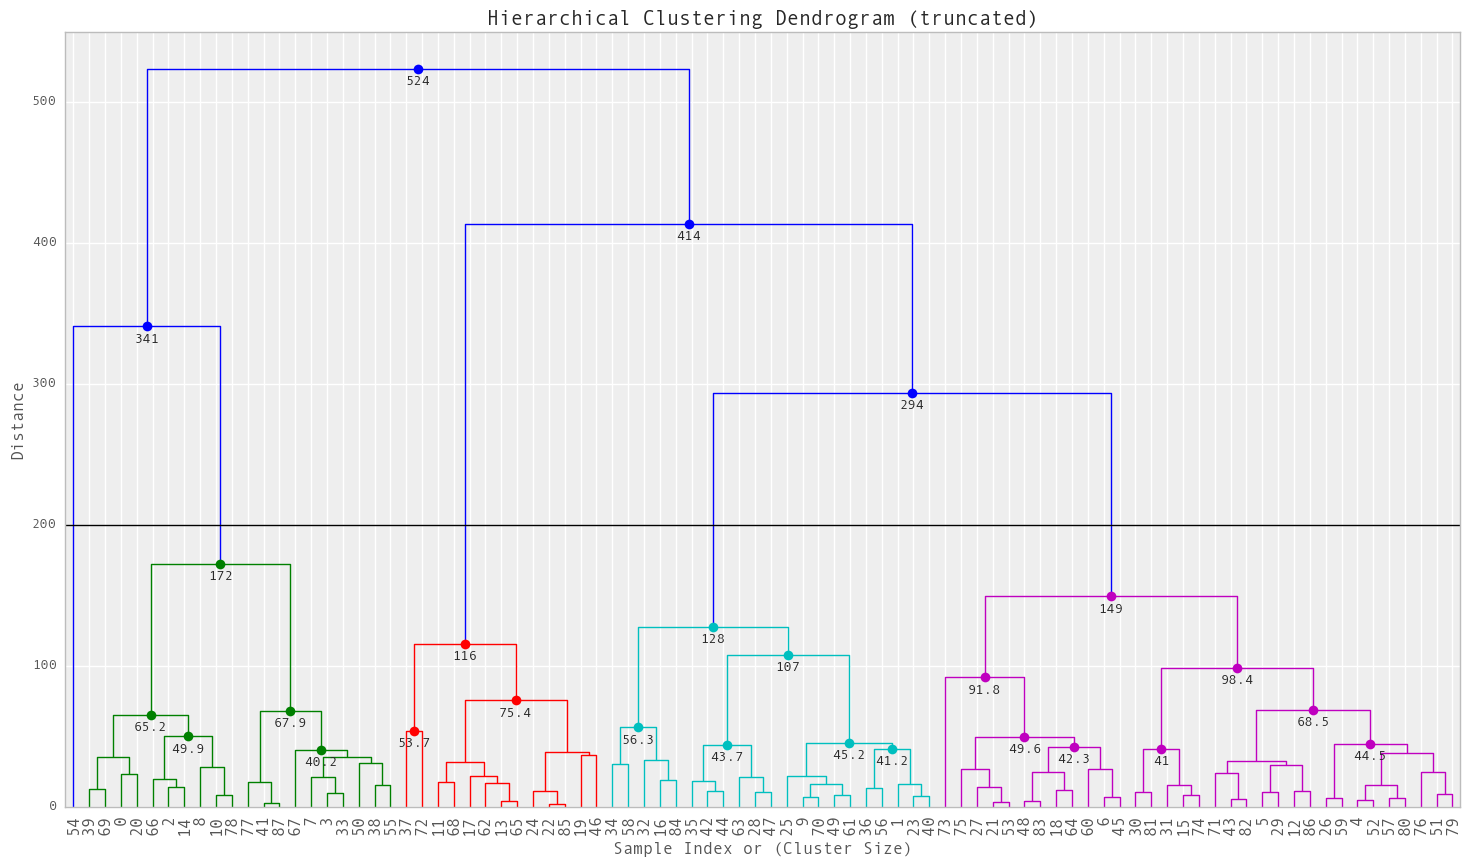

In [361]:
# generate the linkage matrix
Z = linkage(X_reduced2, 'ward')

# plot the dendrogram
plt.figure(figsize=(18,10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=200,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=40,
    max_d=200,
)
plt.show()